# Agrupación de registros - Aprendizaje No Supervisado
---

Usaremos un dataset generado de puntos de consumo con su localización en EEUU. De esta forma, trataremos de agrupar los distintos puntos de medida en función a dos criterios que tiene relación con la curva de consumo eléctrico.

Así pues distinguimos dos objetivos:

**1) Agrupación de registros atendiendo al consumo eléctrico diario de cada punto de medida.**

**2) Agrupación de registros atendiendo al consumo eléctrico medio por tipo de dia.**

Para cada objetivo a tratar, usaremos la localización de los distintos puntos para ubicarlos en el mapa de EEUU usando la librería **folium** para observar así si puntos con un consumo similar (puntos que pertenecen al mismo cluster) se encuentran cercanos en posición, por ejemplo.


# Librerias
---

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import folium
import vincent
from folium.plugins import MarkerCluster, TimestampedGeoJson
from datetime import datetime, timedelta
sns.set_style('darkgrid')

# Recopilación de los datos
---

In [4]:
dataset = pd.read_csv('example_comsumption.csv', sep=",", index_col=0)
dataset.index = pd.to_datetime(dataset.timestamp)
dataset.drop('timestamp', axis=1, inplace=True)
dataset.head()

,point_id,city,state,latitude,longitude,value
timestamp,,,,,,
2013-01-01 01:00:00,702610,Fairbanks,AK,64.83778,-147.71639,1.345049
2013-01-01 02:00:00,702610,Fairbanks,AK,64.83778,-147.71639,1.223677
2013-01-01 03:00:00,702610,Fairbanks,AK,64.83778,-147.71639,1.176375
2013-01-01 04:00:00,702610,Fairbanks,AK,64.83778,-147.71639,1.163767
2013-01-01 05:00:00,702610,Fairbanks,AK,64.83778,-147.71639,1.163812


# Análisis exploratorio
---

## Ingeniería de atributos: horas y tipo de día

In [5]:
dataset['dayofweek'] = dataset.index.dayofweek
dataset['hour'] = dataset.index.hour

dict_dayofweek = {0 : 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
dataset['dayofweek'] = dataset['dayofweek'].map(dict_dayofweek)

## Análisis de los perfiles de las curvas horarias y por tipo de día
---

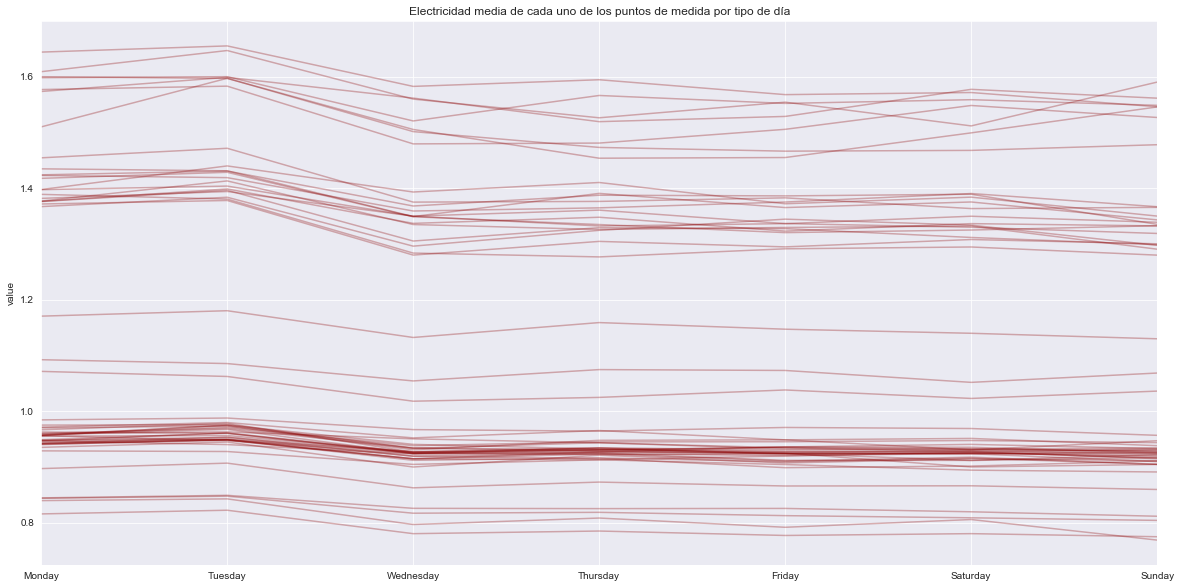

In [6]:
dataset_groupby_city_dayofweek = dataset.groupby(['city', 'dayofweek'])['value'].median()
dataset_groupby_city_dayofweek = dataset_groupby_city_dayofweek.reset_index(['city', 'dayofweek']).reset_index(drop=True)
dataset_value_pivot = dataset_groupby_city_dayofweek.pivot(index='city', columns='dayofweek')
dataset_value_pivot.columns = dataset_value_pivot.columns.droplevel()
dataset_value_pivot = dataset_value_pivot[list(dict_dayofweek.values())]

dataset_groupby_city_hour = dataset.groupby(['city', 'hour'])['value'].median()
dataset_groupby_city_hour = dataset_groupby_city_hour.reset_index(['city', 'hour']).reset_index(drop=True)
dataset_value_pivot_hour = dataset_groupby_city_hour.pivot(index='city', columns='hour')
dataset_value_pivot_hour.columns = dataset_value_pivot_hour.columns.droplevel()
dataset_value_pivot_hour = dataset_value_pivot_hour[list(range(24))]

dataset_value_pivot.T.plot(figsize=(20,10), legend=False, color="darkred", alpha=0.3)
plt.title('Electricidad media de cada uno de los puntos de medida por tipo de día')
plt.xlabel('')
plt.ylabel('value')
plt.show()

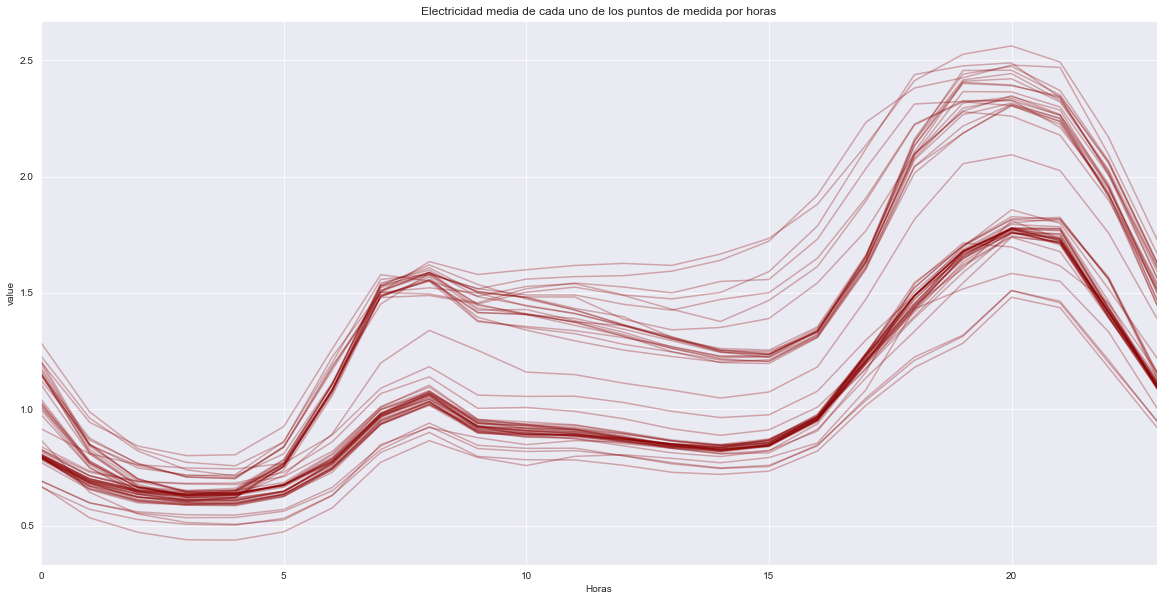

In [7]:
dataset_value_pivot_hour.T.plot(figsize=(20,10), legend=False, color="darkred", alpha=0.3)
plt.title('Electricidad media de cada uno de los puntos de medida por horas')
plt.xlabel('Horas')
plt.ylabel('value')
plt.show()

# Clusterización. Algoritmo *K-Means*
---
El agloritmo **K-Means** es un algoritmo de aprendizaje no supervisado que trata de agrupar registros similares en el mismo grupo. Este algoritmo precisa fijar de antemano el número de grupos a establecer. Existen dos técnicas usuales en la determinación del número de clusters: `método del codo` (*Elbow method*) y `método de la silueta`.

## Métodos
---

### *Elbow Method* o *criterio que minimiza la inercia*

El algoritmo *K-Means* divide un conjunto de $N$ muestras en $K$ subconjuntos, cada uno de ellos descrito por la media $\mu_{j}$ de las muestras del grupo. Los puntos medio de cada grupo se denominan **centroides** (que pueden no ser puntos de $X$). El agloritmo *K-Means* tiene como objetivo **elegir centroides que minimicen la inercia**, o el **criterio de suma de cuadrados dentro del clúster**:

**$$\sum_{i=0}^{n} min_{u_{j} \in K_{j}} (|x_{i} - u_{j}|^{2})$$**

Lógicamente, cuanto menor sea esta distancia media considerando todas las instancias, mejor será el modelo. La regla del codo se utiliza para encontrar el número óptimo de clústers. A medida que aumenta el número de clusters, la suma de la distancia entre cada instancia y el centroide del clúster asociado es más pequeña por lo que la estrategia es tomar el número de clústers que supone un descenso significativo con respecto al número anterior de clústers y a partir del cual esa métrica tiende a estabilizarse.

### *Silhoutte method*

El valor de la silueta para cada instancia clasificada se calcula de la siguiente forma: 

$$\frac{xy}{max(x,y)}$$

donde, $y$ es la distancia media dentro del grupo y $x$ representa la distancia media del grupo más cercano, es decir, la distancia media a las instancias del siguiente grupo más cercano.

Así pues, **el valor de silueta es una medida que establece cómo de similar es un punto con los puntos que se encuentran en su mismo clusters con respecto a los que pertenecen a otro cluster**. Este valor oscila entre -1 y 1 donde un valor cercano a 1 significa que dicho punto está altamente relacionado con los individuos vecinos mientras que un valor cercano a -1 indica que dicho punto tiene una mayor semejanza con los puntos pertenecientes a otro cluster.

Este método es mejor ya que hace que la decisión sobre el número óptimo de grupos sea más significativa y clara aunque, claramente, suponga un esfuerzo computacional pues el cálculo del coeficiente se realiza para cada instancia.

Tomaremos el promedio de la silueta de todos los perfiles para tener una visión global de cómo está funcionando el algoritmo. Realizaremos el experimento con un número de clusters comprendido entre 2 y 30). Es importante escalar cada período dentro del mismo rango para que la magnitud de la energía no interfiera en la selección del clúster.

### Determinación del número óptimo de clústers
---
Es fundamental realizar una estandarización en el consumo horario para tener todos las variables que importan en la métrica de similaridad en la misma escala.

In [8]:
def inertia_plot_update(inertias, ax, delay=1):
    inertias.plot(color='darkred', lw=1, title='Inercia', ax=ax, 
                  xlim=(inertias.index[0], inertias.index[-1]), ylim=(0, inertias.max()))
    
def plot_silhouette(values, y_lower, i, n_clusters, ax):
    size_cluster_i = values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.viridis(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, 
                     values, facecolor=color, 
                     edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
    return y_lower

def format_silhouette_plot(ax, silhouette_avg):
    ax.set_title("Valor de silueta = " + str(round(silhouette_avg, 3)))
    ax.set_xlabel("Silueta")
    ax.set_ylabel("Cluster")
    ax.axvline(x = silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
def plot_final_assignments(x, y, centroids,
                           first_variable, 
                           second_variable,
                           assignments, n_clusters, ax):
    c = plt.cm.viridis(assignments / n_clusters)
    ax.scatter(x, y, marker='.', s=30, 
               lw=0, alpha=0.7, c=c, edgecolor='k')
    ax.scatter(centroids[:, first_variable-1], 
               centroids[:, second_variable-1], marker='o',  
               c='w', s=200, edgecolor='k')
    for i, c in enumerate(centroids):
        ax.scatter(c[first_variable-1], 
                   c[second_variable-1], marker='${}$'.format(i), 
                   s=50, edgecolor='k')

    ax.set_title('{} Clusters'.format(n_clusters))

def plot_distributions_by_n_clusters(n_cluster_list, first_variable, second_variable, dataset):
    inertias = pd.Series(index = n_cluster_list)
    X = dataset.values.copy()
    sc = MinMaxScaler()
    X = sc.fit_transform(X)
    fig, axes = plt.subplots(ncols=2, nrows=max(n_cluster_list), figsize=(12,20))
    fig.tight_layout()
    axes[0][1].scatter(X[:,first_variable-1], X[:, second_variable-1], color="darkgreen", s=10)
    axes[0][1].set_title('Proyección de los puntos usando las variables {0} y {1}'.format(first_variable,
                                                                                          second_variable))
    
    for row, n_clusters in enumerate(range(2, max(n_cluster_list)+1), 1):

        kmeans = KMeans(n_clusters=n_clusters, random_state=10).fit(X)
        centroids, assignments, inertia = \
            kmeans.cluster_centers_, kmeans.labels_, kmeans.inertia_
        inertias[n_clusters] = inertia
        inertia_plot_update(inertias, axes[0][0])
    
        silhouette_avg = silhouette_score(X, assignments)
        sample_silhouette_values = silhouette_samples(X, assignments)
        silhouette_plot, cluster_plot = axes[row]
    
        y_lower = 20
        for i in range(n_clusters):
            y_lower = plot_silhouette(np.sort(sample_silhouette_values[assignments == i]), 
                                      y_lower, i, n_clusters, silhouette_plot)
        format_silhouette_plot(silhouette_plot, silhouette_avg)
        plot_final_assignments(X[:, first_variable-1], X[:, second_variable-1], 
                              centroids, first_variable, second_variable, 
                              assignments, n_clusters, cluster_plot)
        fig.tight_layout()

    fig.suptitle("Análisis KMeans usando el método de la silueta", fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.95)
    
    return X

# Clusterización horaria
---
**Objetivo:** agrupación de los puntos de medida en función a su similitud en cuanto al consumo horario a lo largo de los 365 días de análisis.

## Determinación del número óptimo de clústers (o aglomeraciones)
---

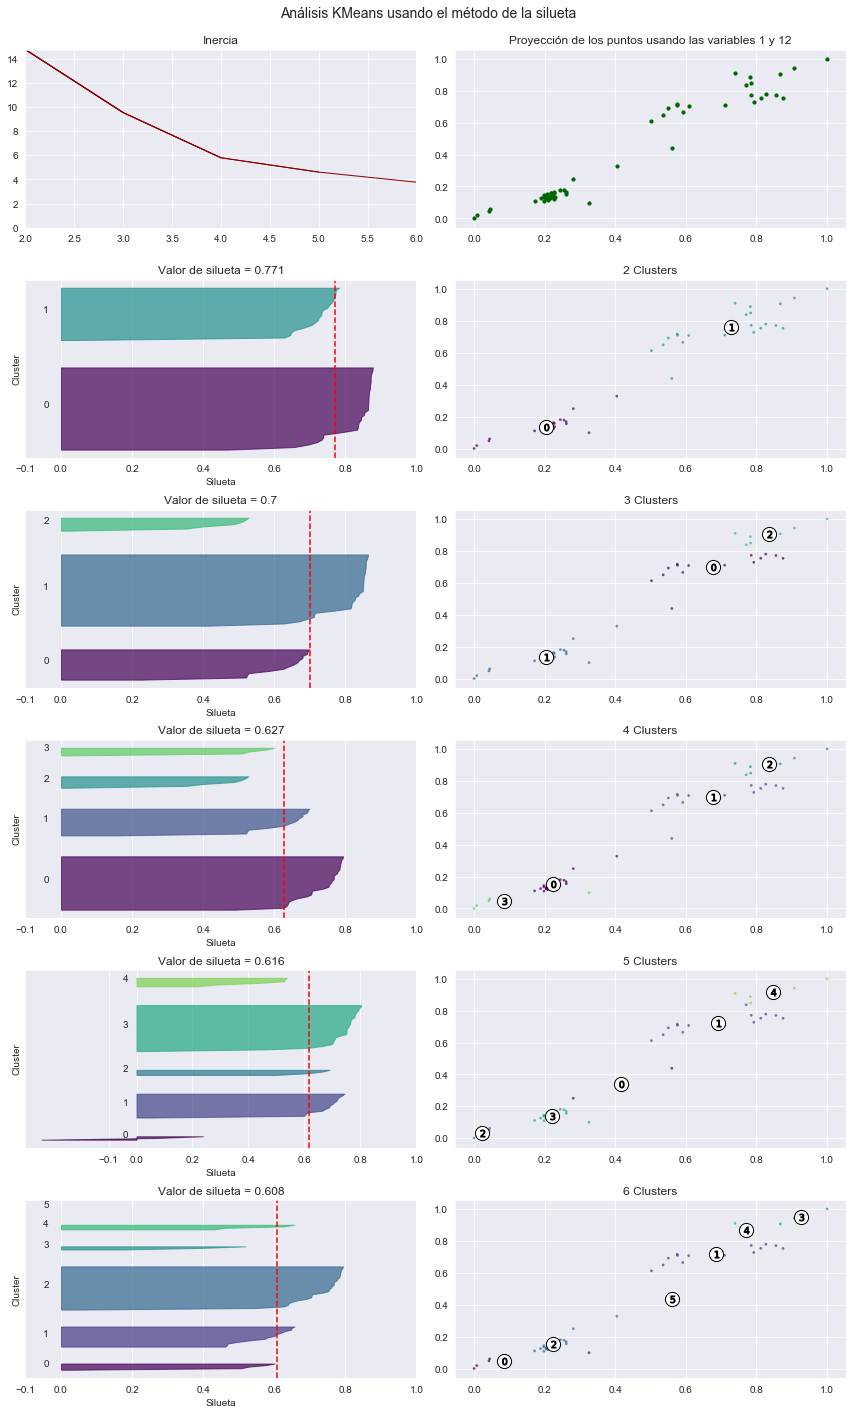

In [9]:
X_hour = plot_distributions_by_n_clusters(n_cluster_list=[2,3,4,5,6],
                                          first_variable=1, second_variable=12,
                                          dataset=dataset_value_pivot_hour)

> **Conclusión:** atendiendo a las métricas el número óptimo de clústers es igual a **4**.

## Visualización gráfica de los 4 clústers junto a la curva media horaria en cada uno de ellos
---

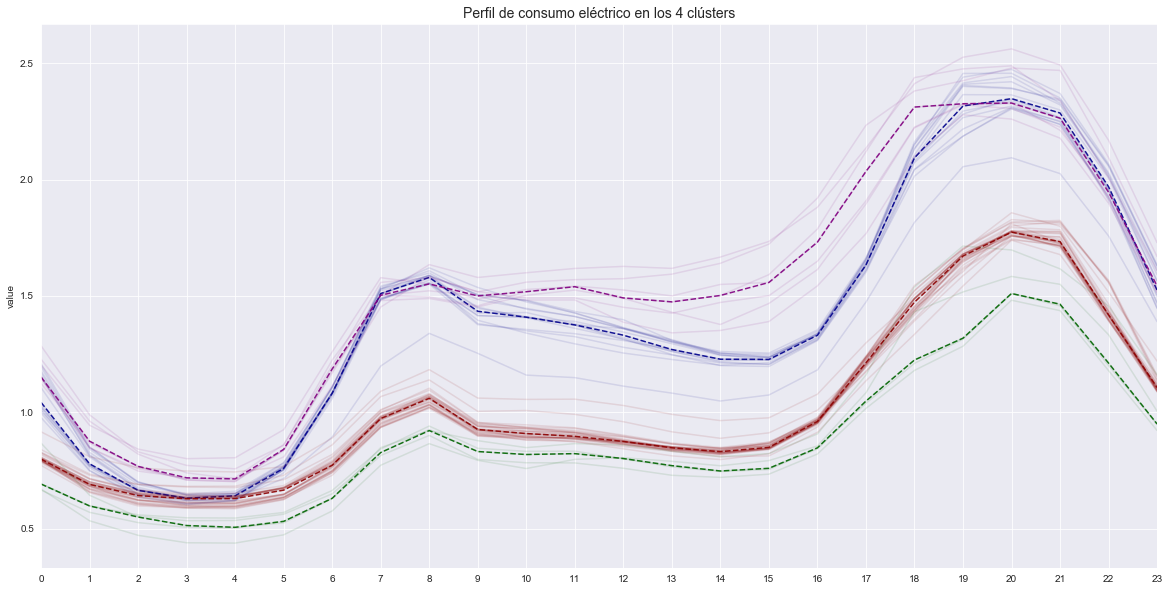

Ciudades asociadas a cada cluster: {1: ['Alpena', 'Bismarck', 'Boston-Logan', 'Bridgeport', 'Burlington', 'Caribou', 'CedarCity', 'Columbus', 'Concord', 'DesMoines', 'Fairbanks', 'Flagstaff', 'Flint', 'Glasgow', 'GrandJunction', 'GreatFalls', 'Indianapolis', 'InternationalFalls', 'Kotzebue', 'LaCrosse', 'Lansing', 'Pocatello', 'Providence', 'RapidCity', 'Reno', 'Sheridan', 'Springfield', 'TraverseCity', 'Williamsport'], 2: ['Astoria', 'LosAngeles', 'Olympia', 'SanFrancisco', 'Tucumcari'], 0: ['Athens', 'AtlanticCity', 'Baltimore', 'Bristol', 'CapeHatteras', 'Charleston', 'FortSmith', 'Greenville-Spartanburg', 'Lexington', 'NewYorkCity-CentralPark', 'Norfolk', 'OklahomaCity', 'StLouis', 'Wichita', 'Wilmington'], 3: ['Honolulu', 'Jackson', 'Miami', 'Mobile', 'NewOrleans', 'SanAntonio', 'Savannah']}


In [10]:
def profile_hourly_by_clusters(dataset, n_clusters, colors):
    fig, ax = plt.subplots(1,1, figsize=(20,10))
    cluster_values = sorted(dataset.index.get_level_values('cluster').unique())

    for cluster, color in zip(cluster_values, colors):
        dataset.xs(cluster, level=1).T.plot(ax=ax, alpha=0.1, legend=False, color=color)
        dataset.xs(cluster, level=1).median().plot(ax=ax, color=color, alpha=0.9, ls='--')
    
    ax.set_xlabel('')
    ax.set_ylabel('value')
    plt.xticks(np.arange(len(list(dataset.columns))), [str(i) for i in list(dataset.columns)])
    plt.title('Perfil de consumo eléctrico en los {0} clústers'.format(n_clusters), fontsize=14)
    plt.show()

def fit_KMeans_Algorithm(X_MinMaxScaler, dataset, n_clusters, colors):
    kmeans = KMeans(n_clusters=n_clusters).fit(X_MinMaxScaler)
    cluster_labels = kmeans.labels_
    cluster_found_sr = pd.Series(cluster_labels, name='cluster')
    dataset = dataset.set_index(cluster_found_sr, append=True)
    df = dataset.reset_index()
    profile_hourly_by_clusters(dataset, n_clusters, colors)
    df = df[['city', 'cluster']]
    dict_cluster = dict()
    for cluster in list(df.cluster.unique()):
        dict_cluster[cluster] = [df.iloc[i,0] for i in range(df.shape[0]) if df.iloc[i,1] == cluster]
    print("Ciudades asociadas a cada cluster:", str(dict_cluster))
    return df

df_city_cluster_hour = fit_KMeans_Algorithm(X_MinMaxScaler = X_hour, 
                                            dataset = dataset_value_pivot_hour, 
                                            n_clusters = 4, 
                                            colors = ['darkblue','darkred', 'darkgreen', 'purple'])

## Localización en el mapa distinguiendo los distintos grupos de puntos de medida
---
Usando de nuevo la librería `folium`, señalamos cada uno de los puntos de medida usando sus coordenadas y **añadimos la funcionalidad de comparar la curva horaria de cada punto de medida con la curva media del clúster asociado**. De esta forma, observamos qué puntos se encuentran más adecuadamente asociada a su clúster.

_Los colores de cada punto corresponden a los colores de la gráfica anterior_

In [11]:
colors_cluster = {0: 'darkblue', 1: 'darkred', 2: 'darkgreen', 3: 'purple'}

USA_coordinates = (45.0000000, -97.0000000)
m = folium.Map(location=USA_coordinates, zoom_start = 3, tiles = "OpenStreetMap")

def insert_city_by_cluster(cluster_dataset, var_group, dataset, cluster, color, title_legend):
    df_map = cluster_dataset.merge(dataset[['city', 'latitude', 'longitude', 
                                            'value', var_group]].drop_duplicates(), on='city')
    df_map_cluster = df_map[df_map.cluster == cluster]
    cities = list(df_map_cluster.city.unique())
    df_map_cluster_median = df_map_cluster.groupby(var_group)['value'].median()
    df_map_cluster_median = df_map_cluster_median.reset_index(var_group).reset_index(drop=True)
    df_map_cluster_median = df_map_cluster_median.rename(columns={'value':'value_cluster_'+str(cluster)})
    for c in cities:
        df_map_cluster_c = df_map_cluster[df_map_cluster.city == c].reset_index(drop=True)
        df_map_cluster_c_median = df_map_cluster_c.groupby(var_group)['value'].median()
        df_map_cluster_c_median = df_map_cluster_c_median.reset_index(var_group).reset_index(drop=True)
        df_map_cluster_c_median = df_map_cluster_c_median.rename(columns={'value': 'value_'+c})
        df_map_plot = df_map_cluster_c_median.\
                    merge(df_map_cluster_median[[var_group,'value_cluster_'+str(cluster)]],
                          on=var_group)
        df_map_plot.index = df_map_plot[var_group]
        df_map_plot = df_map_plot.rename(columns={'value_'+c:c, 
                                                  'value_cluster_'+str(cluster): 'cluster_'+str(cluster)})
        scatter_plot = vincent.Line(df_map_plot[[c, 'cluster_'+str(cluster)]], width=600, height=300)
            
        scatter_plot.axis_titles(x=var_group, y='value')
        scatter_plot.legend(title=title_legend + " " + c)
        
        popup_scatter_plot = folium.Popup(max_width=900).add_child(folium.Vega(scatter_plot, height=350, width=800))
        coordinates_c = (list(df_map_cluster_c['latitude'].unique())[0], 
                         list(df_map_cluster_c['longitude'].unique())[0])
        folium.Marker(location = coordinates_c, tooltip = c, 
                      popup=popup_scatter_plot, icon=folium.Icon(color=color)).add_to(m)

for cluster in colors_cluster:
    insert_city_by_cluster(df_city_cluster_hour, 'hour', dataset, cluster, colors_cluster[cluster], "Hourly Profile")
    
m

# Clusterización por tipo de día
---
## Determinación del número óptimo de clústers
---

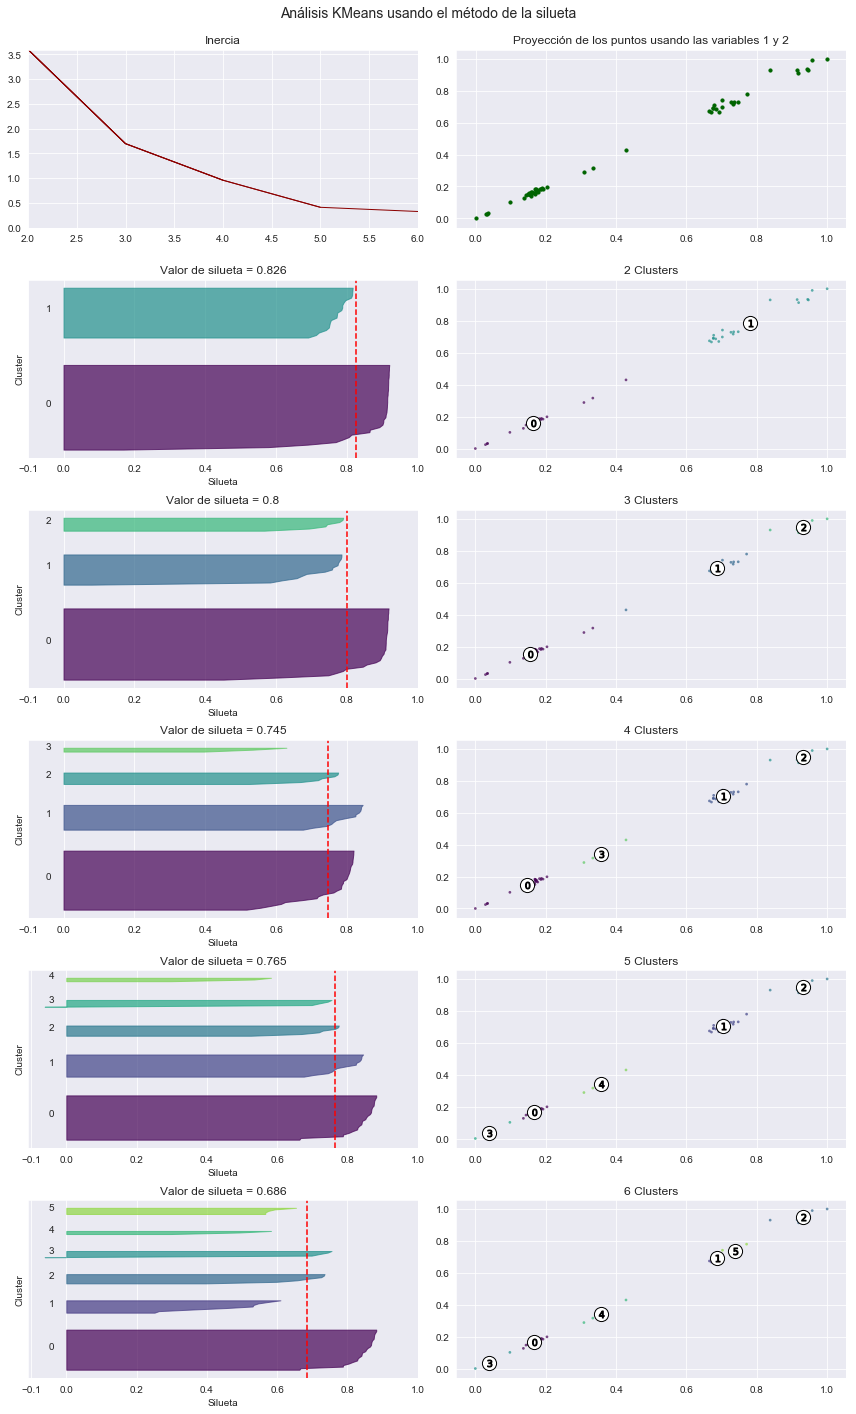

In [12]:
X_dayofweek = plot_distributions_by_n_clusters(n_cluster_list=[2,3,4,5,6], 
                                               first_variable=1, second_variable=2,
                                               dataset=dataset_value_pivot)

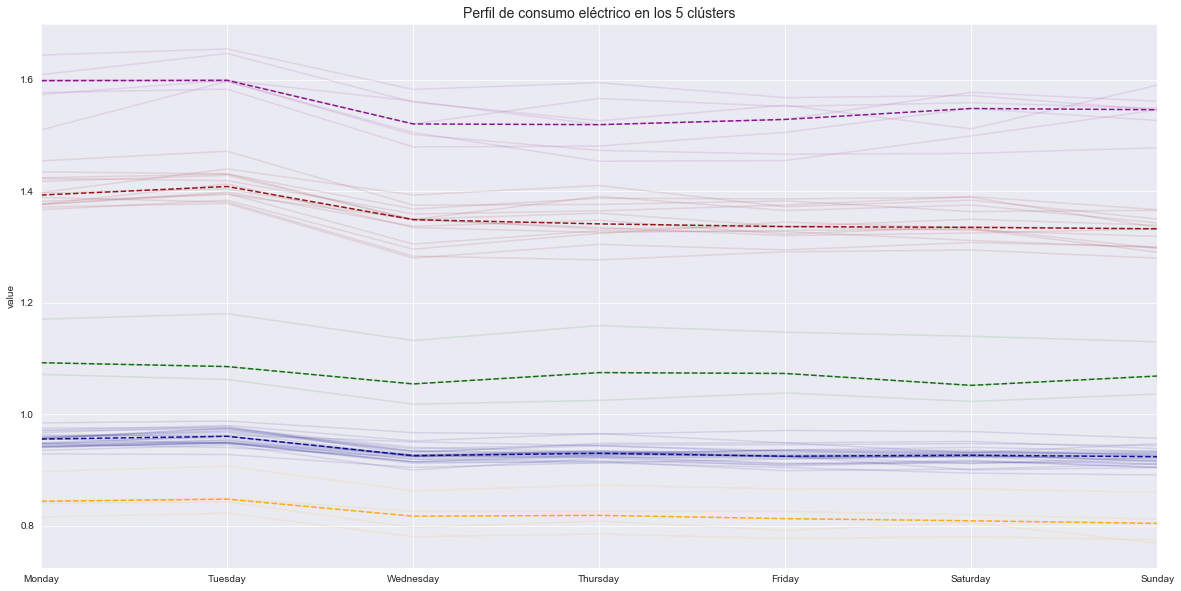

Ciudades asociadas a cada cluster: {0: ['Alpena', 'Bismarck', 'Boston-Logan', 'Bridgeport', 'Burlington', 'Caribou', 'CedarCity', 'Columbus', 'Concord', 'DesMoines', 'Flagstaff', 'Flint', 'Glasgow', 'GrandJunction', 'GreatFalls', 'Indianapolis', 'InternationalFalls', 'LaCrosse', 'Lansing', 'Pocatello', 'Providence', 'RapidCity', 'Reno', 'Sheridan', 'Springfield', 'TraverseCity', 'Williamsport'], 4: ['Astoria', 'LosAngeles', 'Olympia', 'SanFrancisco', 'Tucumcari'], 1: ['Athens', 'AtlanticCity', 'Baltimore', 'Bristol', 'CapeHatteras', 'Charleston', 'FortSmith', 'Greenville-Spartanburg', 'Lexington', 'NewYorkCity-CentralPark', 'OklahomaCity', 'StLouis', 'Wichita', 'Wilmington'], 2: ['Fairbanks', 'Kotzebue', 'Norfolk'], 3: ['Honolulu', 'Jackson', 'Miami', 'Mobile', 'NewOrleans', 'SanAntonio', 'Savannah']}


In [13]:
df_city_cluster_dayofweek = fit_KMeans_Algorithm(X_MinMaxScaler = X_dayofweek, 
                                                 dataset = dataset_value_pivot, 
                                                 n_clusters = 5, 
                                                 colors = ['darkblue','darkred', 'darkgreen', 'purple', 'orange'])

> **Conclusión:** número óptimo de particiones igual a **5**.

## Localización en el mapa distinguiendo los distintos grupos de puntos de medida
---

In [14]:
colors_cluster = {0: 'darkblue', 1: 'darkred', 2: 'darkgreen', 3: 'purple', 4: 'orange'}

USA_coordinates = (45.0000000, -97.0000000)
m = folium.Map(location=USA_coordinates, zoom_start = 3, tiles = "OpenStreetMap")

dict_dayofweek = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday:':5, 'Sunday':6}
dataset['dayofweek'] = dataset['dayofweek'].map(dict_dayofweek)
for cluster in colors_cluster:
    insert_city_by_cluster(df_city_cluster_dayofweek, 'dayofweek', dataset, cluster, colors_cluster[cluster], 
                          'Profile Type of Day')
m